Epoch 1/20
469/469 [==============================] - 4s 6ms/step - loss: 205.1900 - val_loss: 178.1335
Epoch 2/20
469/469 [==============================] - 3s 7ms/step - loss: 173.1568 - val_loss: 169.0962
Epoch 3/20
469/469 [==============================] - 7s 15ms/step - loss: 167.3632 - val_loss: 166.1493
Epoch 4/20
469/469 [==============================] - 9s 18ms/step - loss: 165.0025 - val_loss: 164.5498
Epoch 5/20
469/469 [==============================] - 7s 14ms/step - loss: 163.3616 - val_loss: 162.9159
Epoch 6/20
469/469 [==============================] - 5s 11ms/step - loss: 162.0049 - val_loss: 161.5791
Epoch 7/20
469/469 [==============================] - 6s 12ms/step - loss: 160.7614 - val_loss: 160.6931
Epoch 8/20
469/469 [==============================] - 5s 11ms/step - loss: 159.6940 - val_loss: 159.6261
Epoch 9/20
469/469 [==============================] - 5s 10ms/step - loss: 158.7105 - val_loss: 159.0251
Epoch 10/20
469/469 [==============================] - 5s

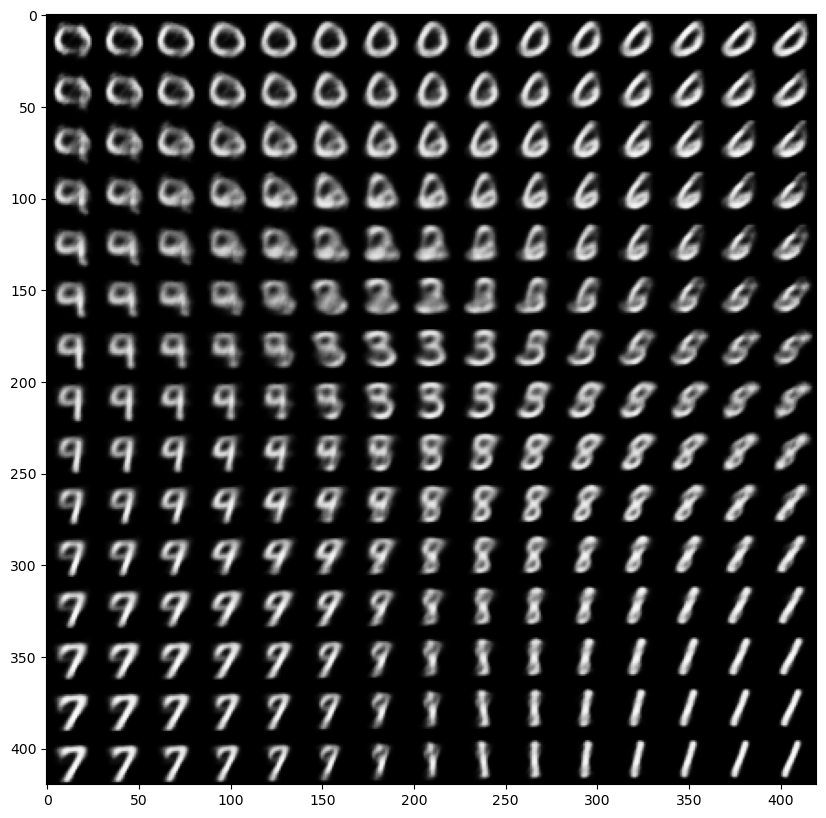

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


# Define parameters
input_shape = (28, 28)  # MNIST image shape
latent_dim = 2  # Dimensionality of the latent space
batch_size = 128
epochs = 20

# Define encoder model
encoder_inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Flatten()(encoder_inputs)
x = tf.keras.layers.Dense(256, activation='relu')(x)
z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_log_var = tf.keras.layers.Dense(latent_dim)(x)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], latent_dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_var])

encoder = tf.keras.models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
# Define decoder model
latent_inputs = tf.keras.layers.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(256, activation='relu')(latent_inputs)
x = tf.keras.layers.Dense(np.prod(input_shape), activation='sigmoid')(x)
decoder_outputs = tf.keras.layers.Reshape(input_shape)(x)

decoder = tf.keras.models.Model(latent_inputs, decoder_outputs, name='decoder')

# Define VAE model
vae_outputs = decoder(encoder(encoder_inputs)[2])
vae = tf.keras.models.Model(encoder_inputs, vae_outputs, name='vae')

# Define loss
# Define loss
def vae_loss(encoder_inputs, vae_outputs):
    encoder_output = encoder(encoder_inputs)
    z_mean, z_log_var, z = encoder_output
    reconstruction_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(encoder_inputs), tf.keras.backend.flatten(vae_outputs))
    reconstruction_loss *= np.prod(input_shape)
    kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
    kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return tf.keras.backend.mean(reconstruction_loss + kl_loss)

vae.compile(optimizer='adam', loss=vae_loss)

# Load data (e.g., MNIST)
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Train the VAE
vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test))

# Generate data from latent space
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

Epoch 1/20
108/108 [==============================] - 1s 5ms/step - loss: 463.1373
Epoch 2/20
108/108 [==============================] - 0s 5ms/step - loss: 435.7697
Epoch 3/20
108/108 [==============================] - 1s 5ms/step - loss: 433.2929
Epoch 4/20
108/108 [==============================] - 1s 5ms/step - loss: 432.1280
Epoch 5/20
108/108 [==============================] - 1s 5ms/step - loss: 431.5189
Epoch 6/20
108/108 [==============================] - 1s 5ms/step - loss: 431.2267
Epoch 7/20
108/108 [==============================] - 1s 5ms/step - loss: 430.8887
Epoch 8/20
108/108 [==============================] - 1s 5ms/step - loss: 430.6776
Epoch 9/20
108/108 [==============================] - 1s 5ms/step - loss: 430.4719
Epoch 10/20
108/108 [==============================] - 1s 5ms/step - loss: 430.2212
Epoch 11/20
108/108 [==============================] - 1s 5ms/step - loss: 430.0540
Epoch 12/20
108/108 [==============================] - 1s 5ms/step - loss: 429.8461
E

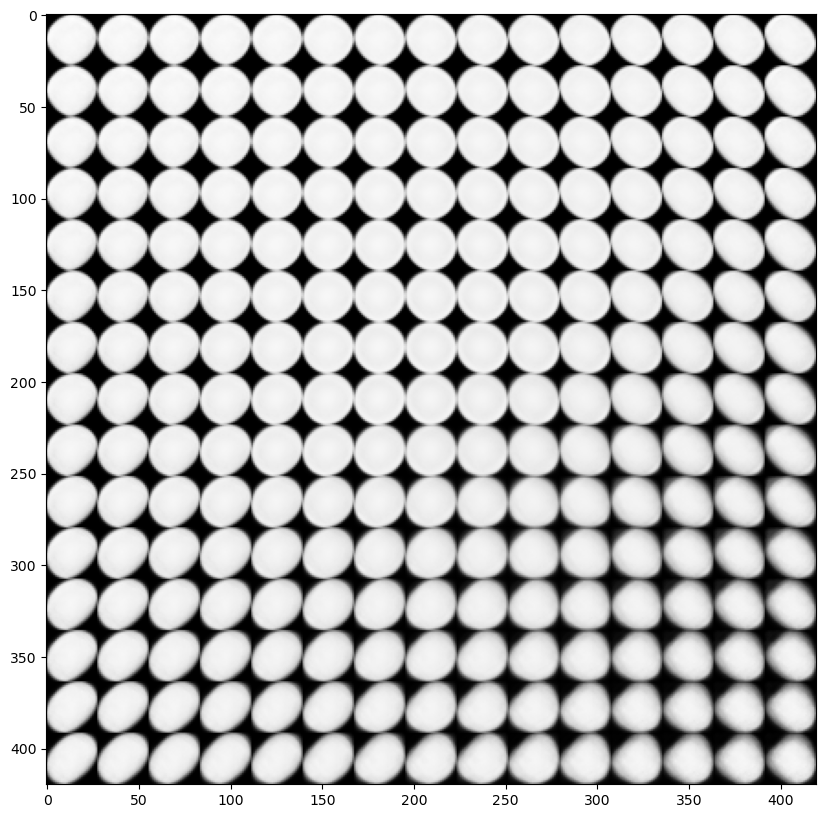

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image

# Define parameters
input_shape = (28, 28)  # Assuming your images are 28x28, change accordingly
latent_dim = 2  # Dimensionality of the latent space
batch_size = 128
epochs = 20

# Define encoder model
encoder_inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Flatten()(encoder_inputs)
x = tf.keras.layers.Dense(256, activation='relu')(x)
z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_log_var = tf.keras.layers.Dense(latent_dim)(x)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], latent_dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_var])

encoder = tf.keras.models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Define decoder model
latent_inputs = tf.keras.layers.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(256, activation='relu')(latent_inputs)
x = tf.keras.layers.Dense(np.prod(input_shape), activation='sigmoid')(x)
decoder_outputs = tf.keras.layers.Reshape(input_shape)(x)
decoder = tf.keras.models.Model(latent_inputs, decoder_outputs, name='decoder')

# Define VAE model
vae_outputs = decoder(encoder(encoder_inputs)[2])
vae = tf.keras.models.Model(encoder_inputs, vae_outputs, name='vae')

# Define loss
def vae_loss(encoder_inputs, vae_outputs):
    encoder_output = encoder(encoder_inputs)
    z_mean, z_log_var, z = encoder_output
    reconstruction_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(encoder_inputs), tf.keras.backend.flatten(vae_outputs))
    reconstruction_loss *= np.prod(input_shape)
    kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
    kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return tf.keras.backend.mean(reconstruction_loss + kl_loss)

vae.compile(optimizer='adam', loss=vae_loss)

# Load and preprocess your own images
image_folder = 'cell_images/Uninfected'
image_files = [file for file in os.listdir(image_folder) if file.endswith(('jpg', 'png', 'jpeg'))]
x_train = []
for image_file in image_files:
    img = Image.open(os.path.join(image_folder, image_file)).convert('L')  # Convert to grayscale if needed
    img = img.resize(input_shape[::-1])  # Resize to match input shape
    img = np.array(img) / 255.0  # Normalize pixel values
    x_train.append(img)
x_train = np.array(x_train)

# Train the VAE
vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size)

# Generate data from latent space
n = 15
digit_size = input_shape[0]  # Adjust accordingly
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image

# Define parameters
input_shape = (32, 32, 3)  # Adjusted to meet ResNet50 input size requirement
latent_dim = 2  # Dimensionality of the latent space
batch_size = 128
epochs = 20

# Define encoder model (ResNet50)
resnet50 = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=input_shape)

encoder_inputs = tf.keras.layers.Input(shape=input_shape)
print(encoder_inputs.shape)
x = resnet50(encoder_inputs)
x = tf.keras.layers.Flatten()(x)
z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_log_var = tf.keras.layers.Dense(latent_dim)(x)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_var])
encoder = tf.keras.models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Define decoder model (Upsampling)
latent_inputs = tf.keras.layers.Input(shape=(latent_dim,))
print(latent_inputs.shape)
x = tf.keras.layers.Dense(256, activation='relu')(latent_inputs)
x = tf.keras.layers.Dense(8 * 8 * 64, activation='relu')(x)  
x = tf.keras.layers.Reshape((8, 8, 64))(x)  
x = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(x)
# Output should have 3 channels for RGB images
decoder_outputs = tf.keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same', activation='sigmoid')(x)

decoder = tf.keras.models.Model(latent_inputs, decoder_outputs, name='decoder')

# Define VAE model
vae_outputs = decoder(z)
vae = tf.keras.models.Model(encoder_inputs, vae_outputs, name='vae')

def vae_loss(encoder_inputs, vae_outputs):
    encoder_output = encoder(encoder_inputs)
    z_mean, z_log_var, _ = encoder_output
    reconstruction_loss = tf.keras.losses.binary_crossentropy(encoder_inputs, vae_outputs)
    reconstruction_loss *= tf.cast(tf.reduce_prod(input_shape), 'float32')
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return tf.reduce_mean(reconstruction_loss + kl_loss)


optimizer = tf.keras.optimizers.Adam(clipvalue=1.0)  # Adjust clipvalue as needed
vae.compile(optimizer=optimizer, loss=vae_loss)

# Load and preprocess your own images
image_folder = 'cell_images/Uninfected'
image_files = [file for file in os.listdir(image_folder) if file.endswith(('jpg', 'png', 'jpeg'))]
x_train = []
for image_file in image_files:
    img = Image.open(os.path.join(image_folder, image_file)).convert('RGB')  # Ensure RGB color channels
    img = img.resize((32, 32))  # Resize to meet ResNet50 input size requirement
    img = np.array(img) / 255.0  # Normalize pixel values
    x_train.append(img)
x_train = np.array(x_train)
print(x_train.shape)


# Train the VAE
vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size)

# Generate data from latent space
n = 15
digit_size = input_shape[0]  # Adjust accordingly
figure = np.zeros((digit_size * n, digit_size * n, 3))  # RGB image, hence 3 channels
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size, 3)  # Reshape to RGB image format
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size, :] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from PIL import Image

# Define parameters
input_shape = (32, 32, 3)  # Adjusted to meet ResNet50 input size requirement
latent_dim = 2  # Dimensionality of the latent space
batch_size = 128
epochs = 20

# Define encoder model (ResNet50)
resnet50 = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=input_shape)

encoder_inputs = tf.keras.layers.Input(shape=input_shape)
x = resnet50(encoder_inputs)
x = tf.keras.layers.Flatten()(x)
z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_log_var = tf.keras.layers.Dense(latent_dim)(x)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_var])
encoder = tf.keras.models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Define decoder model (Upsampling)
latent_inputs = tf.keras.layers.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(256, activation='relu')(latent_inputs)
x = tf.keras.layers.Dense(8 * 8 * 64, activation='relu')(x)  
x = tf.keras.layers.Reshape((8, 8, 64))(x)  
x = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(x)
# Output should have 3 channels for RGB images
decoder_outputs = tf.keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same', activation='sigmoid')(x)

decoder = tf.keras.models.Model(latent_inputs, decoder_outputs, name='decoder')

# Define VAE model
vae_outputs = decoder(z)
vae = tf.keras.models.Model(encoder_inputs, vae_outputs, name='vae')

def vae_loss(encoder_inputs, vae_outputs):
    encoder_output = encoder(encoder_inputs)
    z_mean, z_log_var, _ = encoder_output
    reconstruction_loss = tf.keras.losses.binary_crossentropy(encoder_inputs, vae_outputs)
    reconstruction_loss *= tf.cast(tf.reduce_prod(input_shape), 'float32')
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = -0.5 * tf.reduce_mean(kl_loss, axis=-1)
    return tf.reduce_mean(reconstruction_loss + kl_loss)


optimizer = tf.keras.optimizers.Adam(clipvalue=1.0)  # Adjust clipvalue as needed
vae.compile(optimizer=optimizer, loss=vae_loss)

# Load and preprocess your own images
image_folder = 'cell_images/Uninfected'
image_files = [file for file in os.listdir(image_folder) if file.endswith(('jpg', 'png', 'jpeg'))]
x_train = []
for image_file in image_files:
    img = Image.open(os.path.join(image_folder, image_file)).convert('RGB')  # Ensure RGB color channels
    img = img.resize((32, 32))  # Resize to meet ResNet50 input size requirement
    img = np.array(img) / 255.0  # Normalize pixel values
    x_train.append(img)
x_train = np.array(x_train)
print(x_train.shape)

# Train the VAE
vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size)

# Generate data from latent space
n = 15
digit_size = input_shape[0]  # Adjust accordingly
figure = np.zeros((digit_size * n, digit_size * n, 3))  # RGB image, hence 3 channels
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size, 3)  # Reshape to RGB image format
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size, :] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

shell wise implementation

In [8]:
import numpy as np
import tensorflow as tf
from PIL import Image
import os

# Define parameters
input_shape = (32, 32, 3)  # Adjusted to meet ResNet50 input size requirement
latent_dim = 2  # Dimensionality of the latent space

# Define encoder model (ResNet50)
resnet50 = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=input_shape)

encoder_inputs = tf.keras.layers.Input(shape=input_shape)
print(encoder_inputs.shape)
x = resnet50(encoder_inputs)
x = tf.keras.layers.Flatten()(x)
z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_log_var = tf.keras.layers.Dense(latent_dim)(x)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling)([z_mean, z_log_var])
encoder = tf.keras.models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Define decoder model (Upsampling)
latent_inputs = tf.keras.layers.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(256, activation='relu')(latent_inputs)
x = tf.keras.layers.Dense(8 * 8 * 64, activation='relu')(x)  
x = tf.keras.layers.Reshape((8, 8, 64))(x)  
x = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(x)
# Output should have 3 channels for RGB images
decoder_outputs = tf.keras.layers.Conv2DTranspose(3, kernel_size=3, padding='same', activation='sigmoid')(x)
print(decoder_outputs.shape)
decoder = tf.keras.models.Model(latent_inputs, decoder_outputs, name='decoder')

(None, 32, 32, 3)
(None, 32, 32, 3)


In [9]:
# Define VAE model
vae_outputs = decoder(z)
vae = tf.keras.models.Model(encoder_inputs, vae_outputs, name='vae')
print(x_train.shape)
# Print the summary of the VAE model
vae.summary()

(13779, 32, 32, 3)
Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 1, 1, 2048)   23587712    input_15[0][0]                   
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 2048)         0           resnet50[0][0]                   
__________________________________________________________________________________________________
dense_22 (Dense)                (None, 2)            4098        flatten_5[0][0]                  
_____________________________________________________________________________

In [10]:
# Access batch size from your data
batch_size = x_train.shape[0]  # Assuming x_train is your training data
print("Batch size from data:", batch_size)

# Access batch size from the model's input shape
batch_size_model = vae.input_shape[0]  # Assuming vae is your VAE model
print("Batch size from model input shape:", batch_size_model)


Batch size from data: 13779
Batch size from model input shape: None


In [13]:
# Load and preprocess your own images
image_folder = 'cell_images/Uninfected'
image_files = [file for file in os.listdir(image_folder) if file.endswith(('jpg', 'png', 'jpeg'))]
x_train = []
for image_file in image_files:
    img = Image.open(os.path.join(image_folder, image_file)).convert('RGB')  # Ensure RGB color channels
    img = img.resize((32, 32))  # Resize to meet ResNet50 input size requirement
    img = np.array(img) / 255.0  # Normalize pixel values
    x_train.append(img)
x_train = np.array(x_train)
print("Shape of x_train:", x_train.shape)

Shape of x_train: (13779, 32, 32, 3)


Variational Autoencoder Segementation 